In [1]:
from numpy.random import seed
seed(101)
# from tensorflow import set_random_seed
# set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 1000

In [3]:
os.listdir(r'D:')

['$1Recycle.Bin',
 '$RECYCLE.BIN',
 'DumpStack.log.tmp',
 'input',
 'NPKey.txt',
 'pagefile.sys',
 'sample_submission.csv',
 'System Volume Information',
 'test.csv',
 'test_images',
 'train.csv',
 'train_images']

In [4]:
print(len(os.listdir(r'D:/train_images')))
print(len(os.listdir(r'D:/test_images')))

3662
1928


In [5]:
df_data = pd.read_csv(r'D:/train.csv')
print(df_data.shape)

(3662, 2)


In [6]:
df_data['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [7]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id_code'] + '.png'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

In [8]:
# IMAGE_PATH = r'D:/train/' 

# draw_category_images('diagnosis',4, df_data, IMAGE_PATH)

In [9]:
df_data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [10]:
# # take a random sample of class 0 with size equal to num samples in class 1
# df_0 = df_data[df_data['diagnosis'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# # filter out class 1
# df_1 = df_data[df_data['diagnosis'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# # concat the dataframes
# df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# # shuffle
# df_data = shuffle(df_data)

# df_data['diagnosis'].value_counts()

In [11]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['diagnosis']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(3295, 2)
(367, 2)


In [12]:
df_train['diagnosis'].value_counts()

0    1624
2     899
1     333
4     265
3     174
Name: diagnosis, dtype: int64

In [13]:
df_val['diagnosis'].value_counts()

0    181
2    100
1     37
4     30
3     19
Name: diagnosis, dtype: int64

In [14]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'no_drd')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'drd')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'no_drd')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'drd')
os.mkdir(has_tumor_tissue)

In [15]:
os.listdir('base_dir/train_dir')

['drd', 'no_drd']

In [16]:
df_data.set_index('id_code', inplace=True)

In [17]:
# Get a list of train and val images
train_list = list(df_train['id_code'])
val_list = list(df_val['id_code'])


In [18]:
# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.png'
    # get the label for a certain image
    target = df_data.loc[image,'diagnosis']
    
    # these must match the folder names
    if target == 0:
        label = 'no_drd'
    if target != 0:
        label = 'drd'
    
    # source path to image
    src = os.path.join(r'D:/train_images', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [19]:
# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.png'
    # get the label for a certain image
    target = df_data.loc[image,'diagnosis']
    
    # these must match the folder names
    if target == 0:
        label = 'no_drd'
    if target != 0:
        label = 'drd'
    

    # source path to image
    src = os.path.join(r'D:/train_images', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

In [20]:
print(len(os.listdir('base_dir/train_dir/no_drd')))
print(len(os.listdir('base_dir/train_dir/drd')))

1624
1671


In [21]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/no_drd')))
print(len(os.listdir('base_dir/val_dir/drd')))

181
186


In [22]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = r'D:/test_images'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [23]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 3295 images belonging to 2 classes.
Found 367 images belonging to 2 classes.
Found 367 images belonging to 2 classes.


In [24]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

In [116]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [117]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'drd': 0, 'no_drd': 1}


In [44]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
330/330 [==============================] - 1040s 3s/step - loss: 0.4894 - accuracy: 0.8286 - val_loss: 0.3983 - val_accuracy: 0.8392
Epoch 2/20
330/330 [==============================] - 854s 3s/step - loss: 0.3996 - accuracy: 0.8210 - val_loss: 0.3490 - val_accuracy: 0.8392
Epoch 3/20
330/330 [==============================] - 739s 2s/step - loss: 0.3883 - accuracy: 0.8304 - val_loss: 0.3895 - val_accuracy: 0.8392
Epoch 4/20
330/330 [==============================] - 703s 2s/step - loss: 0.3802 - accuracy: 0.8232 - val_loss: 0.3549 - val_accuracy: 0.8392
Epoch 5/20
330/330 [==============================] - 647s 2s/step - loss: 0.3730 - accuracy: 0.8274 - val_loss: 0.3547 - val_accuracy: 0.8392
Epoch 6/20
330/330 [==============================] - 599s 2s/step - loss: 0.3669 - accuracy: 0.8284 - val_loss: 0.3441 - val_accuracy: 0.8392
Epoch 7/20
330/330 [==============================] - 594s 2s/step - loss: 0.3508 - accuracy: 0.8312 - val_loss: 0.3405 - val_accuracy: 0.839

In [45]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [49]:
# Here the best epoch will be used.



val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.34557998180389404
val_acc: 0.8419618606567383


In [61]:
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


367/367 [==============================] - 36s 98ms/step


In [62]:
predictions.shape

(367, 2)

In [63]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'drd': 0, 'no_drd': 1}

In [64]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_drd', 'drd'])

df_preds.head()

,no_drd,drd
0,0.180965,0.819035
1,0.416962,0.583038
2,0.331804,0.668196
3,0.006891,0.993109
4,0.449063,0.550937


In [65]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['drd']

In [66]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.8354061193044243

In [70]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [71]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [72]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[  2  57]
 [  1 307]]


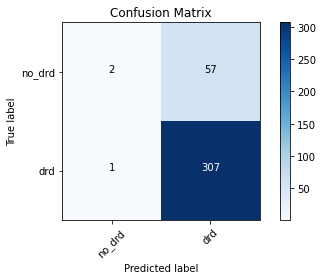

In [74]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_drd', 'drd']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [75]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary,target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      no_drd       0.67      0.03      0.06        59
         drd       0.84      1.00      0.91       308

    accuracy                           0.84       367
   macro avg       0.76      0.52      0.49       367
weighted avg       0.81      0.84      0.78       367



MAKE A TEST SET PREDICTION

In [68]:
# Delete base_dir and it's sub folders to free up disk space.

# shutil.rmtree('base_dir')

In [77]:
#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [78]:
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [79]:
# Transfer the test images into image_dir

test_list = os.listdir(r'D:/test_images')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join(r'D:/test_images', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [80]:
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

1928

In [81]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 1928 images belonging to 1 classes.


In [83]:
num_test_images = 1928

# make sure we are using the best epoch
#model.load_weights('model.h5')

predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1928/1928 [==============================] - 108s 56ms/step


In [84]:
# Are the number of predictions correct?
# Should be 57458.

len(predictions)

1928

In [85]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['no_drd', 'drd'])

df_preds.head()

,no_drd,drd
0,0.261342,0.738658
1,0.250476,0.749524
2,0.059153,0.940847
3,0.302199,0.697801
4,0.149701,0.850299


In [89]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head(100)

,no_drd,drd,file_names
0,0.261342,0.738658,test_images\0005cfc8afb6.png
1,0.250476,0.749524,test_images\003f0afdcd15.png
2,0.059153,0.940847,test_images\006efc72b638.png
3,0.302199,0.697801,test_images\00836aaacf06.png
4,0.149701,0.850299,test_images\009245722fa4.png
...,...,...,...
95,0.030253,0.969747,test_images\0ecaf177e85f.png
96,0.348876,0.651124,test_images\0ed192cd67a2.png
97,0.070498,0.929502,test_images\0edc0c33e929.png
98,0.351120,0.648880,test_images\0ee72c039036.png
